Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
229/229 [==============================] - 14s 43ms/step - loss: 0.0315
Epoch 2/100
229/229 [==============================] - 9s 41ms/step - loss: 0.0237
Epoch 3/100
229/229 [==============================] - 6s 28ms/step - loss: 0.0227
Epoch 4/100
229/229 [==============================] - 8s 35ms/step - loss: 0.0224
Epoch 5/100
229/229 [==============================] - 7s 28ms/step - loss: 0.0222


<ipython-input-1-76f4073064f8>:75: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test_inputs[0, -1, 0] = prediction


1/1 [==============================] - 0s 27ms/step


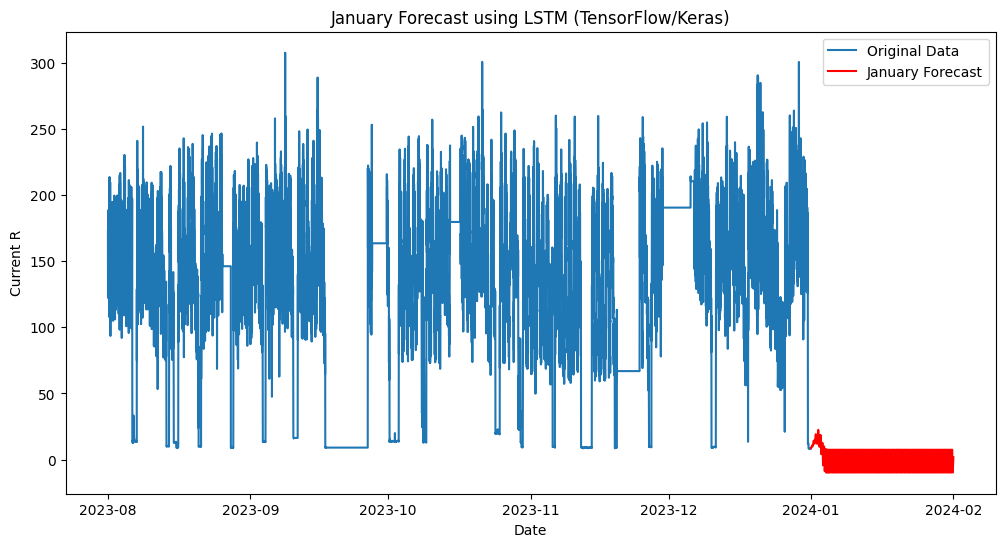

Forecasted data saved to forecasted_data_tensorflow.xlsx


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load the data
file_path = '/content/Main_incomer_MFM_2024-02-07-18-59-33.csv'
data = pd.read_csv(file_path)

# Convert Timestamp to datetime
data['Timestamp'] = pd.to_datetime(data['Timestamp'], format='%d-%m-%Y %H:%M')

# Set Timestamp as the index
data.set_index('Timestamp', inplace=True)

# Handle duplicate timestamps by taking the mean value
data = data.groupby(data.index).mean()

# Ensure the data has a defined frequency
data = data.asfreq('15T')

# Select the "Main incomer Current R" column and handle missing values
data_series = data['Main incomer Current R'].fillna(method='ffill')

# Filter data from August to December
data_series_aug_dec = data_series['2023-08-01':'2023-12-31']

# Normalize the data
scaler = MinMaxScaler(feature_range=(-1, 1))
data_series_scaled = scaler.fit_transform(data_series_aug_dec.values.reshape(-1, 1))

# Prepare the data for LSTM
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data)-seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 60  # Using the past 60 time steps to predict the next one
X, y = create_sequences(data_series_scaled, seq_length)

# Reshape X to be [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

# Define the LSTM model using Keras Sequential API
model = Sequential([
    LSTM(units=50, input_shape=(seq_length, 1)),
    Dense(units=1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Print model summary
model.summary()

# Train the model
history = model.fit(X, y, epochs=100, batch_size=64, verbose=1)

# Prepare forecast for January
test_inputs = data_series_scaled[-seq_length:].tolist()
test_inputs = np.array(test_inputs).reshape(1, seq_length, 1)

january_forecast = []
for i in range(31 * 24 * 4):  # Predicting 31 days with 15-minute intervals
    prediction = model.predict(test_inputs)
    january_forecast.append(prediction[0, 0])
    test_inputs = np.roll(test_inputs, -1)
    test_inputs[0, -1, 0] = prediction

# Inverse transform the forecasted data
january_forecast = scaler.inverse_transform(np.array(january_forecast).reshape(-1, 1))

# Create date range for the forecast
forecast_index = pd.date_range(start=data_series_aug_dec.index[-1], periods=len(january_forecast)+1, freq='15T')[1:]

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(data_series, label='Original Data')
plt.plot(forecast_index, january_forecast, label='January Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Current R')
plt.title('January Forecast using LSTM (TensorFlow/Keras)')
plt.legend()
plt.show()

# Combine original data and forecasted data into a DataFrame
forecast_data = pd.DataFrame({
    'Original Data': data_series,
    'January Forecast': np.concatenate((np.full(len(data_series)-len(january_forecast), np.nan), january_forecast.flatten())),
}, index=data_series.index)

# Export the combined data to an Excel file
excel_filename = 'forecasted_data_tensorflow.xlsx'
forecast_data.to_excel(excel_filename)

print(f'Forecasted data saved to {excel_filename}')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50)                10400     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
229/229 [==============================] - 10s 33ms/step - loss: 0.0337
Epoch 2/100
229/229 [==============================] - 8s 36ms/step - loss: 0.0239
Epoch 3/100
229/229 [==============================] - 8s 37ms/step - loss: 0.0229
Epoch 4/100
229/229 [==============================] - 7s 30ms/step - loss: 0.0226
Epoch 5/100
229/229 [==============================] - 8s 37ms/step - loss: 0.022

<ipython-input-2-3c87557f15a3>:75: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test_inputs[0, -1, 0] = prediction


1/1 [==============================] - 0s 24ms/step


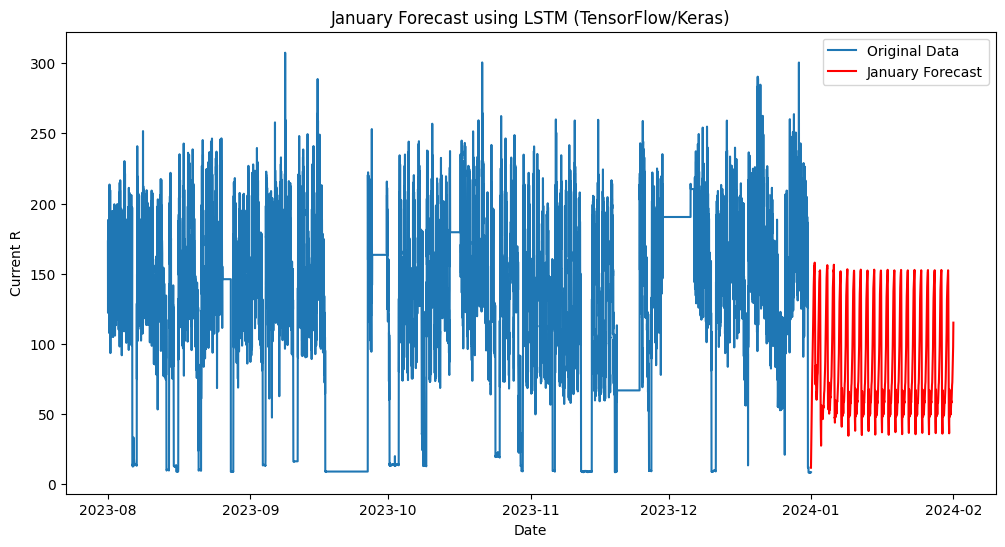

Forecasted data saved to forecasted_data_tensorflow.xlsx


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load the data
file_path = '/content/Main_incomer_MFM_2024-02-07-18-59-33.csv'
data = pd.read_csv(file_path)

# Convert Timestamp to datetime
data['Timestamp'] = pd.to_datetime(data['Timestamp'], format='%d-%m-%Y %H:%M')

# Set Timestamp as the index
data.set_index('Timestamp', inplace=True)

# Handle duplicate timestamps by taking the mean value
data = data.groupby(data.index).mean()

# Ensure the data has a defined frequency
data = data.asfreq('15T')

# Select the "Main incomer Current R" column and handle missing values
data_series = data['Main incomer Current R'].fillna(method='ffill')

# Filter data from August to December
data_series_aug_dec = data_series['2023-08-01':'2023-12-31']

# Normalize the data
scaler = MinMaxScaler(feature_range=(-1, 1))
data_series_scaled = scaler.fit_transform(data_series_aug_dec.values.reshape(-1, 1))

# Prepare the data for LSTM
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data)-seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 60  # Using the past 60 time steps to predict the next one
X, y = create_sequences(data_series_scaled, seq_length)

# Reshape X to be [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

# Define the LSTM model using Keras Sequential API
model = Sequential([
    LSTM(units=50, input_shape=(seq_length, 1)),
    Dense(units=1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Print model summary
model.summary()

# Train the model
history = model.fit(X, y, epochs=100, batch_size=64, verbose=1)

# Prepare forecast for January
test_inputs = data_series_scaled[-seq_length:].tolist()
test_inputs = np.array(test_inputs).reshape(1, seq_length, 1)

january_forecast = []
for i in range(31 * 24 * 4):  # Predicting 31 days with 15-minute intervals
    prediction = model.predict(test_inputs)
    january_forecast.append(prediction[0, 0])
    test_inputs = np.roll(test_inputs, -1)
    test_inputs[0, -1, 0] = prediction

# Inverse transform the forecasted data
january_forecast = scaler.inverse_transform(np.array(january_forecast).reshape(-1, 1))

# Create date range for the forecast
forecast_index = pd.date_range(start='2024-01-01', periods=len(january_forecast), freq='15T')

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(data_series, label='Original Data')
plt.plot(forecast_index, january_forecast, label='January Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Current R')
plt.title('January Forecast using LSTM (TensorFlow/Keras)')
plt.legend()
plt.show()

# Combine original data and forecasted data into a DataFrame
forecast_data = pd.DataFrame({
    'Original Data': data_series,
    'January Forecast': np.nan  # Fill with NaNs initially
}, index=data_series.index)

# Extend the DataFrame to include the forecast period
forecast_data = forecast_data.reindex(forecast_data.index.union(forecast_index))

# Add the forecast data
forecast_data['January Forecast'].loc[forecast_index] = january_forecast.flatten()

# Export the combined data to an Excel file
excel_filename = 'forecasted_data_tensorflow.xlsx'
forecast_data.to_excel(excel_filename)

print(f'Forecasted data saved to {excel_filename}')


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50)                10400     
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
229/229 [==============================] - 11s 37ms/step - loss: 0.0322
Epoch 2/100
229/229 [==============================] - 7s 33ms/step - loss: 0.0238
Epoch 3/100
229/229 [==============================] - 8s 34ms/step - loss: 0.0228
Epoch 4/100
229/229 [==============================] - 8s 37ms/step - loss: 0.0224
Epoch 5/100
229/229 [==============================] - 7s 30ms/step - loss: 0.022

<ipython-input-3-c6c8a750c120>:75: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test_inputs[0, -1, 0] = prediction


1/1 [==============================] - 0s 34ms/step


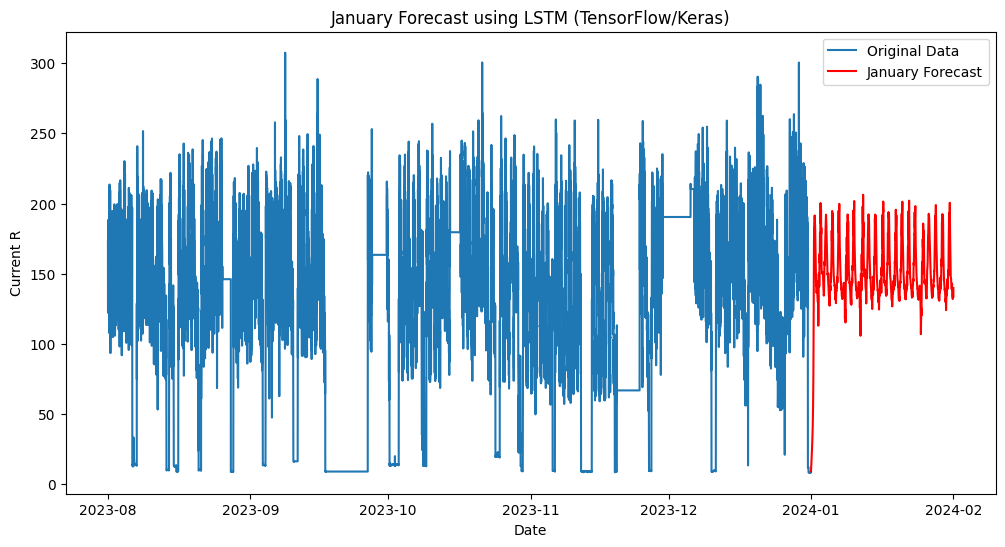

Forecasted data saved to january_forecast_tensorflow.xlsx


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load the data
file_path = '/content/Main_incomer_MFM_2024-02-07-18-59-33.csv'
data = pd.read_csv(file_path)

# Convert Timestamp to datetime
data['Timestamp'] = pd.to_datetime(data['Timestamp'], format='%d-%m-%Y %H:%M')

# Set Timestamp as the index
data.set_index('Timestamp', inplace=True)

# Handle duplicate timestamps by taking the mean value
data = data.groupby(data.index).mean()

# Ensure the data has a defined frequency
data = data.asfreq('15T')

# Select the "Main incomer Current R" column and handle missing values
data_series = data['Main incomer Current R'].fillna(method='ffill')

# Filter data from August to December
data_series_aug_dec = data_series['2023-08-01':'2023-12-31']

# Normalize the data
scaler = MinMaxScaler(feature_range=(-1, 1))
data_series_scaled = scaler.fit_transform(data_series_aug_dec.values.reshape(-1, 1))

# Prepare the data for LSTM
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data)-seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 60  # Using the past 60 time steps to predict the next one
X, y = create_sequences(data_series_scaled, seq_length)

# Reshape X to be [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

# Define the LSTM model using Keras Sequential API
model = Sequential([
    LSTM(units=50, input_shape=(seq_length, 1)),
    Dense(units=1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Print model summary
model.summary()

# Train the model
history = model.fit(X, y, epochs=100, batch_size=64, verbose=1)

# Prepare forecast for January
test_inputs = data_series_scaled[-seq_length:].tolist()
test_inputs = np.array(test_inputs).reshape(1, seq_length, 1)

january_forecast = []
for i in range(31 * 24 * 4):  # Predicting 31 days with 15-minute intervals
    prediction = model.predict(test_inputs)
    january_forecast.append(prediction[0, 0])
    test_inputs = np.roll(test_inputs, -1)
    test_inputs[0, -1, 0] = prediction

# Inverse transform the forecasted data
january_forecast = scaler.inverse_transform(np.array(january_forecast).reshape(-1, 1))

# Create date range for the forecast
forecast_index = pd.date_range(start='2024-01-01', periods=len(january_forecast), freq='15T')

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(data_series, label='Original Data')
plt.plot(forecast_index, january_forecast, label='January Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Current R')
plt.title('January Forecast using LSTM (TensorFlow/Keras)')
plt.legend()
plt.show()

# Combine forecasted data into a DataFrame
forecast_data = pd.DataFrame({
    'Timestamp': forecast_index,
    'January Forecast': january_forecast.flatten()
})

# Export the forecast data to an Excel file
excel_filename = 'january_forecast_tensorflow.xlsx'
forecast_data.to_excel(excel_filename, index=False)

print(f'Forecasted data saved to {excel_filename}')


In [1]:
!pip install pyaudio wave pydub SpeechRecognition translate


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 482.6 kB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 9.6 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × Building wheel for pyaudio (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pyaudio
  Created wheel for wave: filename=Wave-0.0.2-py3-none-any.whl size=1220 sha256=4ff455542619c7eb2df4be5da6fc081d92877fcdbb1f905abeb380428edd0346
  Stored in directory: /root/.cache/pip/wheels/f8/24/4d/1b01c0e32da3eb3fd71bbbc6093fcc557ec3b2d9e532ecd65d
Successfully built wave
Failed to build pyaudio
ERROR: Could not build wheels for pyaudio, which is required to insta

In [10]:
import os
import openai
import re
from translate import Translator
from pydub import AudioSegment
import speech_recognition as sr
import wave
from google.colab import output
from IPython.display import Javascript

# Set the OpenAI API key (replace with your actual key)
os.environ["OPENAI_API_KEY"] = ""
openai.api_key = os.getenv("OPENAI_API_KEY")

def extract_locations(user_input):
    # Regular expressions to extract locations from input
    patterns = [
        re.compile(r"take me from\s+(.+?)\s+to\s+(.+)", re.IGNORECASE),
        re.compile(r"from\s+(.+?)\s+to\s+(.+)", re.IGNORECASE),
        re.compile(r"i want to go from\s+(.+?)\s+to\s+(.+)", re.IGNORECASE)
    ]

    for pattern in patterns:
        match = pattern.search(user_input)
        if match:
            start_location = match.group(1).strip()
            end_location = match.group(2).strip()
            return start_location, end_location
    return None, None

def generate_route_description(start_location, end_location):
    # Prompt for the OpenAI API
    prompt = f"Provide a detailed driving route from {start_location} to {end_location}. Include major turns, landmarks, and distances."

    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt}
        ]
    )

    return response.choices[0].message['content'].strip()

def translate_description(route_description, target_language):
    if target_language == 'en':
        return route_description  # No translation needed if English is selected

    # Initialize translator
    translator = Translator(to_lang=target_language)

    # Split route description into manageable chunks (e.g., sentences)
    def chunks(lst, n):
        for i in range(0, len(lst), n):
            yield lst[i:i + n]

    sentences = route_description.split('. ')
    translated_sentences = []

    # Translate each chunk of sentences and join them back together
    for chunk in chunks(sentences, 5):  # Limiting to 5 sentences per chunk to avoid length issues
        chunk_text = '. '.join(chunk)
        translated_chunk = translator.translate(chunk_text)
        translated_sentences.append(translated_chunk)

    translated_description = '. '.join(translated_sentences)

    return translated_description

def transcribe_audio(audio_path):
    recognizer = sr.Recognizer()
    audio = AudioSegment.from_file(audio_path)
    audio.export("temp.wav", format="wav")
    with sr.AudioFile("temp.wav") as source:
        audio_data = recognizer.record(source)
        text = recognizer.recognize_whisper(audio_data, model="base")
    return text

def record_audio_colab(output_filename):
    RECORD = """
    const sleep = time => new Promise(resolve => setTimeout(resolve, time))
    const b2text = blob => new Promise(resolve => {
        const reader = new FileReader()
        reader.onloadend = e => resolve(e.srcElement.result)
        reader.readAsDataURL(blob)
    })

    var record = time => new Promise(async resolve => {
        stream = await navigator.mediaDevices.getUserMedia({ audio: true })
        recorder = new MediaRecorder(stream)
        chunks = []
        recorder.ondataavailable = e => chunks.push(e.data)
        recorder.start()
        await sleep(time)
        recorder.onstop = async ()=>{
            blob = new Blob(chunks)
            text = await b2text(blob)
            resolve(text)
        }
        recorder.stop()
    })

    var text = await record(5000)
    var audio = document.createElement('audio')
    audio.controls = true
    audio.src = text
    document.body.appendChild(audio)
    """
    display(Javascript(RECORD))
    print("Recording...")

# Run the chatbot
print("Greetings! I am SARATHI, developed by NIT Calicut students.")
while True:
    input_type = input("Enter 'text' for text input or 'audio' for audio input (type 'exit' to quit): ").lower()

    if input_type == 'exit':
        print('Exiting')
        break

    elif input_type == 'text':
        user_input = input("Enter your request: ")

        start_location, end_location = extract_locations(user_input)
        if not start_location or not end_location:
            print("Invalid input format. Please use phrases like 'take me from [start location] to [end location]', 'from [start location] to [end location]', or 'I want to go from [start location] to [end location]'.")
            continue

        route_description = generate_route_description(start_location, end_location)
        print("Route Description (in English):", route_description)

        if len(route_description) > 500:
            print("Route description exceeds 500 characters. Please provide a shorter request.")
            continue

        target_language = input("Enter language code for translation (e.g., 'hi' for Hindi): ").lower()
        translated_description = translate_description(route_description, target_language)
        print(f"Route Description (in {target_language}):", translated_description)

    elif input_type == 'audio':
        audio_output_path = "recorded_audio.wav"
        record_audio_colab(audio_output_path)

        # Wait for the user to stop the recording and save the file manually
        while not os.path.exists(audio_output_path):
            pass

        try:
            user_input = transcribe_audio(audio_output_path)
            print(f"Transcribed Text: {user_input}")

            start_location, end_location = extract_locations(user_input)
            if not start_location or not end_location:
                print("Invalid input format from audio transcription.")
                continue

            route_description = generate_route_description(start_location, end_location)
            print("Route Description (in English):", route_description)

            if len(route_description) > 500:
                print("Route description exceeds 500 characters. Please provide a shorter request.")
                continue

            target_language = input("Enter language code for translation (e.g., 'hi' for Hindi): ").lower()
            translated_description = translate_description(route_description, target_language)
            print(f"Route Description (in {target_language}):", translated_description)

        except Exception as e:
            print(f"Error processing audio: {str(e)}")
            continue

    else:
        print("Invalid input. Please enter 'text' or 'audio'.")


Greetings! I am SARATHI, developed by NIT Calicut students.
Enter 'text' for text input or 'audio' for audio input (type 'exit' to quit): audio


<IPython.core.display.Javascript object>

Recording...


KeyboardInterrupt: 

In [6]:


import os
import openai
import re
from translate import Translator
from pydub import AudioSegment
import speech_recognition as sr
from google.colab import output
from IPython.display import Javascript, display

# Set the OpenAI API key (replace with your actual key)
os.environ["OPENAI_API_KEY"] = ""
openai.api_key = os.getenv("OPENAI_API_KEY")

def extract_locations(user_input):
    # Regular expressions to extract locations from input
    patterns = [
        re.compile(r"take me from\s+(.+?)\s+to\s+(.+)", re.IGNORECASE),
        re.compile(r"from\s+(.+?)\s+to\s+(.+)", re.IGNORECASE),
        re.compile(r"i want to go from\s+(.+?)\s+to\s+(.+)", re.IGNORECASE)
    ]

    for pattern in patterns:
        match = pattern.search(user_input)
        if match:
            start_location = match.group(1).strip()
            end_location = match.group(2).strip()
            return start_location, end_location
    return None, None

def generate_route_description(start_location, end_location):
    # Prompt for the OpenAI API
    prompt = f"Provide a detailed driving route from {start_location} to {end_location}. Include major turns, landmarks, and distances."

    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt}
        ]
    )

    return response.choices[0].message['content'].strip()

def translate_description(route_description, target_language):
    if target_language == 'en':
        return route_description  # No translation needed if English is selected

    # Initialize translator
    translator = Translator(to_lang=target_language)

    # Split route description into manageable chunks (e.g., sentences)
    def chunks(lst, n):
        for i in range(0, len(lst), n):
            yield lst[i:i + n]

    sentences = route_description.split('. ')
    translated_sentences = []

    # Translate each chunk of sentences and join them back together
    for chunk in chunks(sentences, 5):  # Limiting to 5 sentences per chunk to avoid length issues
        chunk_text = '. '.join(chunk)
        translated_chunk = translator.translate(chunk_text)
        translated_sentences.append(translated_chunk)

    translated_description = '. '.join(translated_sentences)

    return translated_description

def transcribe_audio(audio_path):
    recognizer = sr.Recognizer()
    audio = AudioSegment.from_file(audio_path)
    audio.export("temp.wav", format="wav")
    with sr.AudioFile("temp.wav") as source:
        audio_data = recognizer.record(source)
        text = recognizer.recognize_google(audio_data)
    return text

def record_audio_colab():
    RECORD_AUDIO = """
    const sleep = time => new Promise(resolve => setTimeout(resolve, time));
    const b2text = blob => new Promise(resolve => {
        const reader = new FileReader();
        reader.onloadend = e => resolve(e.srcElement.result);
        reader.readAsDataURL(blob);
    });

    var record = time => new Promise(async resolve => {
        stream = await navigator.mediaDevices.getUserMedia({ audio: true });
        recorder = new MediaRecorder(stream);
        chunks = [];
        recorder.ondataavailable = e => chunks.push(e.data);
        recorder.start();
        await sleep(time);
        recorder.onstop = async () => {
            blob = new Blob(chunks);
            text = await b2text(blob);
            resolve(text);
        };
        recorder.stop();
    });

    var text = await record(5000);
    var audio = document.createElement('audio');
    audio.controls = true;
    audio.src = text;
    document.body.appendChild(audio);
    var link = document.createElement('a');
    link.href = text;
    link.download = 'recorded_audio.wav';
    link.innerHTML = 'Download recorded audio';
    document.body.appendChild(link);
    """
    display(Javascript(RECORD_AUDIO))
    print("Recording for 5 seconds...")

# Run the chatbot
print("Greetings! I am SARATHI, developed by NIT Calicut students.")
while True:
    input_type = input("Enter 'text' for text input or 'audio' for audio input (type 'exit' to quit): ").lower()

    if input_type == 'exit':
        print('Exiting')
        break

    elif input_type == 'text':
        user_input = input("Enter your request: ")

        start_location, end_location = extract_locations(user_input)
        if not start_location or not end_location:
            print("Invalid input format. Please use phrases like 'take me from [start location] to [end location]', 'from [start location] to [end location]', or 'I want to go from [start location] to [end location]'.")
            continue

        route_description = generate_route_description(start_location, end_location)
        print("Route Description (in English):", route_description)

        if len(route_description) > 500:
            print("Route description exceeds 500 characters. Please provide a shorter request.")
            continue

        target_language = input("Enter language code for translation (e.g., 'hi' for Hindi): ").lower()
        translated_description = translate_description(route_description, target_language)
        print(f"Route Description (in {target_language}):", translated_description)

    elif input_type == 'audio':
        record_audio_colab()

        audio_path = input("After recording, enter the path to the saved audio file (e.g., 'recorded_audio.wav'): ")

        try:
            user_input = transcribe_audio(audio_path)
            print(f"Transcribed Text: {user_input}")

            start_location, end_location = extract_locations(user_input)
            if not start_location or not end_location:
                print("Invalid input format from audio transcription.")
                continue

            route_description = generate_route_description(start_location, end_location)
            print("Route Description (in English):", route_description)

            if len(route_description) > 500:
                print("Route description exceeds 500 characters. Please provide a shorter request.")
                continue

            target_language = input("Enter language code for translation (e.g., 'hi' for Hindi): ").lower()
            translated_description = translate_description(route_description, target_language)
            print(f"Route Description (in {target_language}):", translated_description)

        except Exception as e:
            print(f"Error processing audio: {str(e)}")
            continue

    else:
        print("Invalid input. Please enter 'text' or 'audio'.")


Greetings! I am SARATHI, developed by NIT Calicut students.
Enter 'text' for text input or 'audio' for audio input (type 'exit' to quit): audio


<IPython.core.display.Javascript object>

Recording for 5 seconds...
After recording, enter the path to the saved audio file (e.g., 'recorded_audio.wav'): 
Error processing audio: [Errno 2] No such file or directory: ''
Enter 'text' for text input or 'audio' for audio input (type 'exit' to quit): exit
Exiting


In [7]:
import os
import openai
import re
from translate import Translator
from pydub import AudioSegment
import speech_recognition as sr
from IPython.display import display, Audio, HTML
from google.colab.output import eval_js
from base64 import b64decode
from google.colab import output
# Set the OpenAI API key (replace with your actual key)
os.environ["OPENAI_API_KEY"] = ""
openai.api_key = os.getenv("OPENAI_API_KEY")

def extract_locations(user_input):
    # Regular expressions to extract locations from input
    patterns = [
        re.compile(r"take me from\s+(.+?)\s+to\s+(.+)", re.IGNORECASE),
        re.compile(r"from\s+(.+?)\s+to\s+(.+)", re.IGNORECASE),
        re.compile(r"i want to go from\s+(.+?)\s+to\s+(.+)", re.IGNORECASE)
    ]

    for pattern in patterns:
        match = pattern.search(user_input)
        if match:
            start_location = match.group(1).strip()
            end_location = match.group(2).strip()
            return start_location, end_location
    return None, None

def generate_route_description(start_location, end_location):
    # Prompt for the OpenAI API
    prompt = f"Provide a detailed driving route from {start_location} to {end_location}. Include major turns, landmarks, and distances."

    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt}
        ]
    )

    return response.choices[0].message['content'].strip()

def translate_description(route_description, target_language):
    if target_language == 'en':
        return route_description  # No translation needed if English is selected

    # Initialize translator
    translator = Translator(to_lang=target_language)

    # Split route description into manageable chunks (e.g., sentences)
    def chunks(lst, n):
        for i in range(0, len(lst), n):
            yield lst[i:i + n]

    sentences = route_description.split('. ')
    translated_sentences = []

    # Translate each chunk of sentences and join them back together
    for chunk in chunks(sentences, 5):  # Limiting to 5 sentences per chunk to avoid length issues
        chunk_text = '. '.join(chunk)
        translated_chunk = translator.translate(chunk_text)
        translated_sentences.append(translated_chunk)

    translated_description = '. '.join(translated_sentences)

    return translated_description

def transcribe_audio(audio_path):
    recognizer = sr.Recognizer()
    audio = AudioSegment.from_file(audio_path)
    audio.export("temp.wav", format="wav")
    with sr.AudioFile("temp.wav") as source:
        audio_data = recognizer.record(source)
        text = recognizer.recognize_google(audio_data)
    return text

def record_audio_colab():
    RECORD_AUDIO_HTML = """
    <script>
    var my_div = document.createElement("DIV");
    var my_p = document.createElement("P");
    var my_btn = document.createElement("BUTTON");
    var my_audio = document.createElement("AUDIO");

    my_p.innerHTML = "Press the button to start recording";
    my_btn.innerHTML = "Start Recording";
    my_btn.style.width = "200px";
    my_btn.style.height = "100px";
    my_btn.style.fontSize = "20px";
    my_btn.style.marginTop = "20px";

    my_audio.controls = true;
    my_audio.style.marginTop = "20px";

    my_div.appendChild(my_p);
    my_div.appendChild(my_btn);
    my_div.appendChild(my_audio);
    document.body.appendChild(my_div);

    var my_stream;
    var my_recorder;
    var my_chunks = [];
    var my_audio_url;

    my_btn.onclick = async function() {
      if (my_btn.innerHTML === "Start Recording") {
        my_stream = await navigator.mediaDevices.getUserMedia({ audio: true });
        my_recorder = new MediaRecorder(my_stream);
        my_recorder.ondataavailable = function(e) {
          my_chunks.push(e.data);
        };
        my_recorder.onstop = function() {
          var my_blob = new Blob(my_chunks, { 'type' : 'audio/wav; codecs=MS_PCM' });
          my_audio_url = window.URL.createObjectURL(my_blob);
          my_audio.src = my_audio_url;
          var reader = new FileReader();
          reader.readAsDataURL(my_blob);
          reader.onloadend = function() {
              var base64data = reader.result;
              google.colab.kernel.invokeFunction('notebook.upload_audio', [base64data], {});
          }
        };
        my_recorder.start();
        my_btn.innerHTML = "Stop Recording";
        my_p.innerHTML = "Recording... Click the button to stop.";
      } else {
        my_recorder.stop();
        my_stream.getTracks().forEach(function(track) {
          track.stop();
        });
        my_btn.innerHTML = "Start Recording";
        my_p.innerHTML = "Press the button to start recording";
      }
    }
    </script>
    """
    display(HTML(RECORD_AUDIO_HTML))

def save_audio(base64_audio):
    audio_data = base64_audio.split(',')[1]
    audio_bytes = b64decode(audio_data)
    with open('recorded_audio.wav', 'wb') as f:
        f.write(audio_bytes)
    return 'recorded_audio.wav'

output.register_callback('notebook.upload_audio', save_audio)

# Run the chatbot
print("Greetings! I am SARATHI, developed by NIT Calicut students.")
while True:
    input_type = input("Enter 'text' for text input or 'audio' for audio input (type 'exit' to quit): ").lower()

    if input_type == 'exit':
        print('Exiting')
        break

    elif input_type == 'text':
        user_input = input("Enter your request: ")

        start_location, end_location = extract_locations(user_input)
        if not start_location or not end_location:
            print("Invalid input format. Please use phrases like 'take me from [start location] to [end location]', 'from [start location] to [end location]', or 'I want to go from [start location] to [end location]'.")
            continue

        route_description = generate_route_description(start_location, end_location)
        print("Route Description (in English):", route_description)

        if len(route_description) > 500:
            print("Route description exceeds 500 characters. Please provide a shorter request.")
            continue

        target_language = input("Enter language code for translation (e.g., 'hi' for Hindi): ").lower()
        translated_description = translate_description(route_description, target_language)
        print(f"Route Description (in {target_language}):", translated_description)

    elif input_type == 'audio':
        record_audio_colab()

        # Wait for user to finish recording
        print("Please record your audio and then provide the path to the saved audio file (e.g., 'recorded_audio.wav').")

        audio_path = input("Enter the path to the saved audio file: ")

        try:
            user_input = transcribe_audio(audio_path)
            print(f"Transcribed Text: {user_input}")

            start_location, end_location = extract_locations(user_input)
            if not start_location or not end_location:
                print("Invalid input format from audio transcription.")
                continue

            route_description = generate_route_description(start_location, end_location)
            print("Route Description (in English):", route_description)

            if len(route_description) > 500:
                print("Route description exceeds 500 characters. Please provide a shorter request.")
                continue

            target_language = input("Enter language code for translation (e.g., 'hi' for Hindi): ").lower()
            translated_description = translate_description(route_description, target_language)
            print(f"Route Description (in {target_language}):", translated_description)

        except Exception as e:
            print(f"Error processing audio: {str(e)}")
            continue

    else:
        print("Invalid input. Please enter 'text' or 'audio'.")


Greetings! I am SARATHI, developed by NIT Calicut students.
Enter 'text' for text input or 'audio' for audio input (type 'exit' to quit): audio


Please record your audio and then provide the path to the saved audio file (e.g., 'recorded_audio.wav').
Enter the path to the saved audio file: /content/f3c2a826-20f5-47b7-916c-3452f281be6f.wav
Transcribed Text: take me take me from kurnool to Google
Route Description (in English): I'm sorry, but I cannot provide real-time driving routes as I don't have access to live traffic data or the ability to calculate routes. I recommend using a GPS navigation system or a mapping service like Google Maps for accurate directions from Kurnool to Google headquarters in Mountain View, California. Let me know if you need any other information or assistance.
Enter language code for translation (e.g., 'hi' for Hindi): hi
Route Description (in hi): माफ़ करें, लेकिन मैं रीयल - टाइम ड्राइविंग रूट नहीं दे सकता, क्योंकि मेरे पास लाइव ट्रैफ़िक डेटा या रूट की गणना करने की क्षमता नहीं है। मैं माउंटेन व्यू, कैलिफ़ोर्निया में कुरनूल से Google मुख्यालय तक सटीक दिशाओं के लिए GPS नेविगेशन सिस्टम या Google मानचित्र

Please record your audio and then provide the path to the saved audio file (e.g., 'recorded_audio.wav').
Enter the path to the saved audio file: /content/90e495db-ae63-4b64-b682-914c11b53f73.wav
Transcribed Text: take me from thrissur to Kochi take me from Mumbai to Pune by Road and give me the landmarks
Route Description (in English): Driving from Thrissur to Kochi:

1. Start in Thrissur, Kerala and head south on NH66
2. Travel for about 35 km and enter the city of Kochi

Landmarks:
- Chalakudy
- Amballur
- Angamaly
- Aluva
- Kalamassery

Driving from Mumbai to Pune:

1. Start in Mumbai, Maharashtra and head east on Mumbai Pune Expressway
2. Travel for about 150 km

Landmarks:
- Lonavala
- Khandala
- Kamshet
- Talegaon
- Chakan

I hope this helps! Let me know if you need more information.
Enter language code for translation (e.g., 'hi' for Hindi): exit
Route Description (in exit): 'EXIT' IS AN INVALID TARGET LANGUAGE . EXAMPLE: LANGPAIR=EN|IT USING 2 LETTER ISO OR RFC3066 LIKE ZH-CN. 

In [6]:
import os
import openai
import re
from translate import Translator
from pydub import AudioSegment
import speech_recognition as sr
import gradio as gr
from google.colab import output
from base64 import b64decode

# Set the OpenAI API key (replace with your actual key)
os.environ["OPENAI_API_KEY"] = ""
openai.api_key = os.getenv("OPENAI_API_KEY")

def extract_locations(user_input):
    patterns = [
        re.compile(r"take me from\s+(.+?)\s+to\s+(.+)", re.IGNORECASE),
        re.compile(r"from\s+(.+?)\s+to\s+(.+)", re.IGNORECASE),
        re.compile(r"i want to go from\s+(.+?)\s+to\s+(.+)", re.IGNORECASE)
    ]

    for pattern in patterns:
        match = pattern.search(user_input)
        if match:
            start_location = match.group(1).strip()
            end_location = match.group(2).strip()
            return start_location, end_location
    return None, None

def generate_route_description(start_location, end_location):
    prompt = f"Provide a detailed driving route from {start_location} to {end_location}. Include major turns, landmarks, and distances."
    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt}
        ]
    )
    return response.choices[0].message['content'].strip()

def translate_description(route_description, target_language):
    if target_language == 'en':
        return route_description

    translator = Translator(to_lang=target_language)

    def chunks(lst, n):
        for i in range(0, len(lst), n):
            yield lst[i:i + n]

    sentences = route_description.split('. ')
    translated_sentences = []

    for chunk in chunks(sentences, 5):
        chunk_text = '. '.join(chunk)
        translated_chunk = translator.translate(chunk_text)
        translated_sentences.append(translated_chunk)

    translated_description = '. '.join(translated_sentences)
    return translated_description

def transcribe_audio(audio_path):
    recognizer = sr.Recognizer()
    audio = AudioSegment.from_file(audio_path)
    audio.export("temp.wav", format="wav")
    with sr.AudioFile("temp.wav") as source:
        audio_data = recognizer.record(source)
        text = recognizer.recognize_google(audio_data)
    return text

def process_text_input(user_input, target_language):
    start_location, end_location = extract_locations(user_input)
    if not start_location or not end_location:
        return "Invalid input format. Please use phrases like 'take me from [start location] to [end location]', 'from [start location] to [end location]', or 'I want to go from [start location] to [end location]'."

    route_description = generate_route_description(start_location, end_location)
    if len(route_description) > 500:
        return "Route description exceeds 500 characters. Please provide a shorter request."

    translated_description = translate_description(route_description, target_language)
    return translated_description

def process_audio_input(audio, target_language):
    try:
        audio_path = "recorded_audio.wav"
        with open(audio_path, "wb") as f:
            f.write(audio.read())

        user_input = transcribe_audio(audio_path)
        start_location, end_location = extract_locations(user_input)
        if not start_location or not end_location:
            return "Invalid input format from audio transcription."

        route_description = generate_route_description(start_location, end_location)
        if len(route_description) > 500:
            return "Route description exceeds 500 characters. Please provide a shorter request."

        translated_description = translate_description(route_description, target_language)
        return translated_description

    except Exception as e:
        return f"Error processing audio: {str(e)}"

def save_audio(base64_audio):
    audio_data = base64_audio.split(',')[1]
    audio_bytes = b64decode(audio_data)
    with open('recorded_audio.wav', 'wb') as f:
        f.write(audio_bytes)
    return 'recorded_audio.wav'

output.register_callback('notebook.upload_audio', save_audio)

# Define Gradio interface
with gr.Blocks() as demo:
    gr.Markdown("## Greetings! I am SARATHI, developed by NIT Calicut students.")
    with gr.Tab("Text Input"):
        text_input = gr.Textbox(label="Enter your request")
        language_input = gr.Textbox(label="Enter language code for translation (e.g., 'hi' for Hindi)")
        text_output = gr.Textbox(label="Route Description")
        text_button = gr.Button("Get Route Description")
        text_button.click(process_text_input, inputs=[text_input, language_input], outputs=text_output)

    with gr.Tab("Audio Input"):
        audio_input = gr.Audio(type="file")
        audio_language_input = gr.Textbox(label="Enter language code for translation (e.g., 'hi' for Hindi)")
        audio_output = gr.Textbox(label="Route Description")
        audio_button = gr.Button("Get Route Description")
        audio_button.click(process_audio_input, inputs=[audio_input, audio_language_input], outputs=audio_output)

# Launch the Gradio interface
demo.launch()


ValueError: Invalid value for parameter `type`: file. Please choose from one of: ['numpy', 'filepath']

In [7]:
import os
import openai
import re
from translate import Translator
from pydub import AudioSegment
import speech_recognition as sr
import gradio as gr
from google.colab import output
from base64 import b64decode

# Set the OpenAI API key (replace with your actual key)
os.environ["OPENAI_API_KEY"] = ""
openai.api_key = os.getenv("OPENAI_API_KEY")

def extract_locations(user_input):
    patterns = [
        re.compile(r"take me from\s+(.+?)\s+to\s+(.+)", re.IGNORECASE),
        re.compile(r"from\s+(.+?)\s+to\s+(.+)", re.IGNORECASE),
        re.compile(r"i want to go from\s+(.+?)\s+to\s+(.+)", re.IGNORECASE)
    ]

    for pattern in patterns:
        match = pattern.search(user_input)
        if match:
            start_location = match.group(1).strip()
            end_location = match.group(2).strip()
            return start_location, end_location
    return None, None

def generate_route_description(start_location, end_location):
    prompt = f"Provide a detailed driving route from {start_location} to {end_location}. Include major turns, landmarks, and distances."
    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt}
        ]
    )
    return response.choices[0].message['content'].strip()

def translate_description(route_description, target_language):
    if target_language == 'en':
        return route_description

    translator = Translator(to_lang=target_language)

    def chunks(lst, n):
        for i in range(0, len(lst), n):
            yield lst[i:i + n]

    sentences = route_description.split('. ')
    translated_sentences = []

    for chunk in chunks(sentences, 5):
        chunk_text = '. '.join(chunk)
        translated_chunk = translator.translate(chunk_text)
        translated_sentences.append(translated_chunk)

    translated_description = '. '.join(translated_sentences)
    return translated_description

def transcribe_audio(audio_path):
    recognizer = sr.Recognizer()
    audio = AudioSegment.from_file(audio_path)
    audio.export("temp.wav", format="wav")
    with sr.AudioFile("temp.wav") as source:
        audio_data = recognizer.record(source)
        text = recognizer.recognize_google(audio_data)
    return text

def process_text_input(user_input, target_language):
    start_location, end_location = extract_locations(user_input)
    if not start_location or not end_location:
        return "Invalid input format. Please use phrases like 'take me from [start location] to [end location]', 'from [start location] to [end location]', or 'I want to go from [start location] to [end location]'."

    route_description = generate_route_description(start_location, end_location)
    if len(route_description) > 500:
        return "Route description exceeds 500 characters. Please provide a shorter request."

    translated_description = translate_description(route_description, target_language)
    return translated_description

def process_audio_input(audio, target_language):
    try:
        audio_path = "recorded_audio.wav"
        audio.save(audio_path)

        user_input = transcribe_audio(audio_path)
        start_location, end_location = extract_locations(user_input)
        if not start_location or not end_location:
            return "Invalid input format from audio transcription."

        route_description = generate_route_description(start_location, end_location)
        if len(route_description) > 500:
            return "Route description exceeds 500 characters. Please provide a shorter request."

        translated_description = translate_description(route_description, target_language)
        return translated_description

    except Exception as e:
        return f"Error processing audio: {str(e)}"

def save_audio(base64_audio):
    audio_data = base64_audio.split(',')[1]
    audio_bytes = b64decode(audio_data)
    with open('recorded_audio.wav', 'wb') as f:
        f.write(audio_bytes)
    return 'recorded_audio.wav'

output.register_callback('notebook.upload_audio', save_audio)

# Define Gradio interface
with gr.Blocks() as demo:
    gr.Markdown("## Greetings! I am SARATHI, developed by NIT Calicut students.")
    with gr.Tab("Text Input"):
        text_input = gr.Textbox(label="Enter your request")
        language_input = gr.Textbox(label="Enter language code for translation (e.g., 'hi' for Hindi)")
        text_output = gr.Textbox(label="Route Description")
        text_button = gr.Button("Get Route Description")
        text_button.click(process_text_input, inputs=[text_input, language_input], outputs=text_output)

    with gr.Tab("Audio Input"):
        audio_input = gr.Audio(type="filepath")
        audio_language_input = gr.Textbox(label="Enter language code for translation (e.g., 'hi' for Hindi)")
        audio_output = gr.Textbox(label="Route Description")
        audio_button = gr.Button("Get Route Description")
        audio_button.click(process_audio_input, inputs=[audio_input, audio_language_input], outputs=audio_output)

# Launch the Gradio interface
demo.launch()


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://785cc7d1428750402b.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [8]:
!pip install gradio --upgrade


In [9]:
import os
import openai
import re
from translate import Translator
from pydub import AudioSegment
import speech_recognition as sr
import gradio as gr
from base64 import b64decode

# Set the OpenAI API key (replace with your actual key)
os.environ["OPENAI_API_KEY"] = "your_openai_api_key_here"
openai.api_key = os.getenv("OPENAI_API_KEY")

def extract_locations(user_input):
    patterns = [
        re.compile(r"take me from\s+(.+?)\s+to\s+(.+)", re.IGNORECASE),
        re.compile(r"from\s+(.+?)\s+to\s+(.+)", re.IGNORECASE),
        re.compile(r"i want to go from\s+(.+?)\s+to\s+(.+)", re.IGNORECASE)
    ]

    for pattern in patterns:
        match = pattern.search(user_input)
        if match:
            start_location = match.group(1).strip()
            end_location = match.group(2).strip()
            return start_location, end_location
    return None, None

def generate_route_description(start_location, end_location):
    prompt = f"Provide a detailed driving route from {start_location} to {end_location}. Include major turns, landmarks, and distances."
    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt}
        ]
    )
    return response.choices[0].message['content'].strip()

def translate_description(route_description, target_language):
    if target_language == 'en':
        return route_description

    translator = Translator(to_lang=target_language)

    def chunks(lst, n):
        for i in range(0, len(lst), n):
            yield lst[i:i + n]

    sentences = route_description.split('. ')
    translated_sentences = []

    for chunk in chunks(sentences, 5):
        chunk_text = '. '.join(chunk)
        translated_chunk = translator.translate(chunk_text)
        translated_sentences.append(translated_chunk)

    translated_description = '. '.join(translated_sentences)
    return translated_description

def transcribe_audio(audio_path):
    recognizer = sr.Recognizer()
    audio = AudioSegment.from_file(audio_path)
    audio.export("temp.wav", format="wav")
    with sr.AudioFile("temp.wav") as source:
        audio_data = recognizer.record(source)
        text = recognizer.recognize_google(audio_data)
    return text

def process_text_input(user_input, target_language):
    start_location, end_location = extract_locations(user_input)
    if not start_location or not end_location:
        return "Invalid input format. Please use phrases like 'take me from [start location] to [end location]', 'from [start location] to [end location]', or 'I want to go from [start location] to [end location]'."

    route_description = generate_route_description(start_location, end_location)
    if len(route_description) > 500:
        return "Route description exceeds 500 characters. Please provide a shorter request."

    translated_description = translate_description(route_description, target_language)
    return translated_description

def process_audio_input(audio, target_language):
    try:
        audio_path = "recorded_audio.wav"
        audio.save(audio_path)

        user_input = transcribe_audio(audio_path)
        start_location, end_location = extract_locations(user_input)
        if not start_location or not end_location:
            return "Invalid input format from audio transcription."

        route_description = generate_route_description(start_location, end_location)
        if len(route_description) > 500:
            return "Route description exceeds 500 characters. Please provide a shorter request."

        translated_description = translate_description(route_description, target_language)
        return translated_description

    except Exception as e:
        return f"Error processing audio: {str(e)}"

def save_audio(base64_audio):
    audio_data = base64_audio.split(',')[1]
    audio_bytes = b64decode(audio_data)
    with open('recorded_audio.wav', 'wb') as f:
        f.write(audio_bytes)
    return 'recorded_audio.wav'

# Define Gradio interface
with gr.Blocks() as demo:
    gr.Markdown("## Greetings! I am SARATHI, developed by NIT Calicut students.")
    with gr.Tab("Text Input"):
        text_input = gr.Textbox(label="Enter your request")
        language_input = gr.Textbox(label="Enter language code for translation (e.g., 'hi' for Hindi)")
        text_output = gr.Textbox(label="Route Description")
        text_button = gr.Button("Get Route Description")
        text_button.click(process_text_input, inputs=[text_input, language_input], outputs=text_output)

    with gr.Tab("Audio Input"):
        audio_input = gr.Audio(type="filepath")
        audio_language_input = gr.Textbox(label="Enter language code for translation (e.g., 'hi' for Hindi)")
        audio_output = gr.Textbox(label="Route Description")
        audio_button = gr.Button("Get Route Description")
        audio_button.click(process_audio_input, inputs=[audio_input, audio_language_input], outputs=audio_output)

# Launch the Gradio interface
demo.launch()


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://77e4f7c93c47b6fca6.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [12]:
import os
import openai
import re
from translate import Translator
from pydub import AudioSegment
import speech_recognition as sr
import gradio as gr
from base64 import b64decode

# Set the OpenAI API key (replace with your actual key)
os.environ["OPENAI_API_KEY"] = ""
openai.api_key = os.getenv("OPENAI_API_KEY")

def extract_locations(user_input):
    patterns = [
        re.compile(r"take me from\s+(.+?)\s+to\s+(.+)", re.IGNORECASE),
        re.compile(r"from\s+(.+?)\s+to\s+(.+)", re.IGNORECASE),
        re.compile(r"i want to go from\s+(.+?)\s+to\s+(.+)", re.IGNORECASE)
    ]

    for pattern in patterns:
        match = pattern.search(user_input)
        if match:
            start_location = match.group(1).strip()
            end_location = match.group(2).strip()
            return start_location, end_location
    return None, None

def generate_route_description(start_location, end_location):
    prompt = f"Provide a detailed driving route from {start_location} to {end_location}. Include major turns, landmarks, and distances."
    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt}
        ]
    )
    return response.choices[0].message['content'].strip()

def translate_description(route_description, target_language):
    if target_language == 'en':
        return route_description

    translator = Translator(to_lang=target_language)

    def chunks(lst, n):
        for i in range(0, len(lst), n):
            yield lst[i:i + n]

    sentences = route_description.split('. ')
    translated_sentences = []

    for chunk in chunks(sentences, 5):
        chunk_text = '. '.join(chunk)
        translated_chunk = translator.translate(chunk_text)
        translated_sentences.append(translated_chunk)

    translated_description = '. '.join(translated_sentences)
    return translated_description

def transcribe_audio(audio_path):
    recognizer = sr.Recognizer()
    audio = AudioSegment.from_file(audio_path)
    audio.export("temp.wav", format="wav")
    with sr.AudioFile("temp.wav") as source:
        audio_data = recognizer.record(source)
        text = recognizer.recognize_google(audio_data)
    return text

def process_text_input(user_input, target_language):
    start_location, end_location = extract_locations(user_input)
    if not start_location or not end_location:
        return "Invalid input format. Please use phrases like 'take me from [start location] to [end location]', 'from [start location] to [end location]', or 'I want to go from [start location] to [end location]'."

    route_description = generate_route_description(start_location, end_location)
    if len(route_description) > 500:
        return "Route description exceeds 500 characters. Please provide a shorter request."

    translated_description = translate_description(route_description, target_language)
    return translated_description

def process_audio_input(audio_path, target_language):
    try:
        user_input = transcribe_audio(audio_path)
        start_location, end_location = extract_locations(user_input)
        if not start_location or not end_location:
            return "Invalid input format from audio transcription."

        route_description = generate_route_description(start_location, end_location)
        if len(route_description) > 500:
            return "Route description exceeds 500 characters. Please provide a shorter request."

        translated_description = translate_description(route_description, target_language)
        return translated_description

    except Exception as e:
        return f"Error processing audio: {str(e)}"

def save_audio(base64_audio):
    audio_data = base64_audio.split(',')[1]
    audio_bytes = b64decode(audio_data)
    with open('recorded_audio.wav', 'wb') as f:
        f.write(audio_bytes)
    return 'recorded_audio.wav'

# Define Gradio interface
with gr.Blocks() as demo:
    gr.Markdown("## Greetings! I am SARATHI, developed by NIT Calicut students.")
    with gr.Tab("Text Input"):
        text_input = gr.Textbox(label="Enter your request")
        language_input = gr.Textbox(label="Enter language code for translation (e.g., 'hi' for Hindi)")
        text_output = gr.Textbox(label="Route Description")
        text_button = gr.Button("Get Route Description")
        text_button.click(process_text_input, inputs=[text_input, language_input], outputs=text_output)

    with gr.Tab("Audio Input"):
        audio_input = gr.Audio(type="filepath")
        audio_language_input = gr.Textbox(label="Enter language code for translation (e.g., 'hi' for Hindi)")
        audio_output = gr.Textbox(label="Route Description")
        audio_button = gr.Button("Get Route Description")
        audio_button.click(process_audio_input, inputs=[audio_input, audio_language_input], outputs=audio_output)

# Launch the Gradio interface
demo.launch()


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://8c2aa7a5d7aa2d0634.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [13]:
import os
import openai
import re
from translate import Translator
from pydub import AudioSegment
import speech_recognition as sr
import gradio as gr
from base64 import b64decode

# Set the OpenAI API key (replace with your actual key)
os.environ["OPENAI_API_KEY"] = ""
openai.api_key = os.getenv("OPENAI_API_KEY")

def extract_locations(user_input):
    patterns = [
        re.compile(r"take me from\s+(.+?)\s+to\s+(.+)", re.IGNORECASE),
        re.compile(r"from\s+(.+?)\s+to\s+(.+)", re.IGNORECASE),
        re.compile(r"i want to go from\s+(.+?)\s+to\s+(.+)", re.IGNORECASE)
    ]

    for pattern in patterns:
        match = pattern.search(user_input)
        if match:
            start_location = match.group(1).strip()
            end_location = match.group(2).strip()
            return start_location, end_location
    return None, None

def generate_route_description(start_location, end_location):
    prompt = f"Provide a detailed driving route from {start_location} to {end_location}. Include major turns, landmarks, and distances."
    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt}
        ]
    )
    return response.choices[0].message['content'].strip()

def translate_description(route_description, target_language):
    if target_language == 'en':
        return route_description

    translator = Translator(to_lang=target_language)

    def chunks(lst, n):
        for i in range(0, len(lst), n):
            yield lst[i:i + n]

    sentences = route_description.split('. ')
    translated_sentences = []

    for chunk in chunks(sentences, 5):
        chunk_text = '. '.join(chunk)
        translated_chunk = translator.translate(chunk_text)
        translated_sentences.append(translated_chunk)

    translated_description = '. '.join(translated_sentences)
    return translated_description

def transcribe_audio(audio_path):
    recognizer = sr.Recognizer()
    audio = AudioSegment.from_file(audio_path)
    audio.export("temp.wav", format="wav")
    try:
        with sr.AudioFile("temp.wav") as source:
            audio_data = recognizer.record(source)
            text = recognizer.recognize_google(audio_data)
            return text
    except FileNotFoundError:
        return "Error: temp.wav file not found."
    except sr.UnknownValueError:
        return "Error: Speech Recognition could not understand the audio."
    except sr.RequestError as e:
        return f"Error: Could not request results from Google Speech Recognition service; {e}"

def process_text_input(user_input, target_language):
    start_location, end_location = extract_locations(user_input)
    if not start_location or not end_location:
        return "Invalid input format. Please use phrases like 'take me from [start location] to [end location]', 'from [start location] to [end location]', or 'I want to go from [start location] to [end location]'."

    route_description = generate_route_description(start_location, end_location)
    if len(route_description) > 500:
        return "Route description exceeds 500 characters. Please provide a shorter request."

    translated_description = translate_description(route_description, target_language)
    return translated_description

def process_audio_input(audio_path, target_language):
    try:
        user_input = transcribe_audio(audio_path)
        start_location, end_location = extract_locations(user_input)
        if not start_location or not end_location:
            return "Invalid input format from audio transcription."

        route_description = generate_route_description(start_location, end_location)
        if len(route_description) > 500:
            return "Route description exceeds 500 characters. Please provide a shorter request."

        translated_description = translate_description(route_description, target_language)
        return translated_description

    except Exception as e:
        return f"Error processing audio: {str(e)}"

def save_audio(base64_audio):
    audio_data = base64_audio.split(',')[1]
    audio_bytes = b64decode(audio_data)
    with open('recorded_audio.wav', 'wb') as f:
        f.write(audio_bytes)
    return 'recorded_audio.wav'

# Define Gradio interface
with gr.Blocks() as demo:
    gr.Markdown("## Greetings! I am SARATHI, developed by NIT Calicut students.")
    with gr.Tab("Text Input"):
        text_input = gr.Textbox(label="Enter your request")
        language_input = gr.Textbox(label="Enter language code for translation (e.g., 'hi' for Hindi)")
        text_output = gr.Textbox(label="Route Description")
        text_button = gr.Button("Get Route Description")
        text_button.click(process_text_input, inputs=[text_input, language_input], outputs=text_output)

    with gr.Tab("Audio Input"):
        audio_input = gr.Audio(type="filepath")
        audio_language_input = gr.Textbox(label="Enter language code for translation (e.g., 'hi' for Hindi)")
        audio_output = gr.Textbox(label="Route Description")
        audio_button = gr.Button("Get Route Description")
        audio_button.click(process_audio_input, inputs=[audio_input, audio_language_input], outputs=audio_output)

# Launch the Gradio interface
demo.launch()


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://2e17c1239a399f55ff.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [14]:
import os
import openai
import re
from translate import Translator
from pydub import AudioSegment
import speech_recognition as sr
import gradio as gr
from base64 import b64decode

# Set the OpenAI API key (replace with your actual key)
os.environ["OPENAI_API_KEY"] = ""
openai.api_key = os.getenv("OPENAI_API_KEY")

def extract_locations(user_input):
    patterns = [
        re.compile(r"take me from\s+(.+?)\s+to\s+(.+)", re.IGNORECASE),
        re.compile(r"from\s+(.+?)\s+to\s+(.+)", re.IGNORECASE),
        re.compile(r"i want to go from\s+(.+?)\s+to\s+(.+)", re.IGNORECASE)
    ]

    for pattern in patterns:
        match = pattern.search(user_input)
        if match:
            start_location = match.group(1).strip()
            end_location = match.group(2).strip()
            return start_location, end_location
    return None, None

def generate_route_description(start_location, end_location):
    prompt = f"Provide a detailed driving route from {start_location} to {end_location}. Include major turns, landmarks, and distances."
    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt}
        ]
    )
    return response.choices[0].message['content'].strip()

def translate_description(route_description, target_language):
    if target_language == 'en':
        return route_description

    translator = Translator(to_lang=target_language)

    def chunks(lst, n):
        for i in range(0, len(lst), n):
            yield lst[i:i + n]

    sentences = route_description.split('. ')
    translated_sentences = []

    for chunk in chunks(sentences, 5):
        chunk_text = '. '.join(chunk)
        translated_chunk = translator.translate(chunk_text)
        translated_sentences.append(translated_chunk)

    translated_description = '. '.join(translated_sentences)
    return translated_description

def transcribe_audio(audio_path):
    try:
        recognizer = sr.Recognizer()
        audio = AudioSegment.from_file(audio_path)
        audio.export("temp.wav", format="wav")

        with sr.AudioFile("temp.wav") as source:
            audio_data = recognizer.record(source)
            text = recognizer.recognize_google(audio_data)
            return text

    except FileNotFoundError:
        return "Error: temp.wav file not found."
    except sr.UnknownValueError:
        return "Error: Speech Recognition could not understand the audio."
    except sr.RequestError as e:
        return f"Error: Could not request results from Google Speech Recognition service; {e}"
    except Exception as e:
        return f"Unexpected error: {str(e)}"

def process_text_input(user_input, target_language):
    start_location, end_location = extract_locations(user_input)
    if not start_location or not end_location:
        return "Invalid input format. Please use phrases like 'take me from [start location] to [end location]', 'from [start location] to [end location]', or 'I want to go from [start location] to [end location]'."

    route_description = generate_route_description(start_location, end_location)
    if len(route_description) > 500:
        return "Route description exceeds 500 characters. Please provide a shorter request."

    translated_description = translate_description(route_description, target_language)
    return translated_description

def process_audio_input(audio_path, target_language):
    try:
        user_input = transcribe_audio(audio_path)
        start_location, end_location = extract_locations(user_input)
        if not start_location or not end_location:
            return "Invalid input format from audio transcription."

        route_description = generate_route_description(start_location, end_location)
        if len(route_description) > 500:
            return "Route description exceeds 500 characters. Please provide a shorter request."

        translated_description = translate_description(route_description, target_language)
        return translated_description

    except Exception as e:
        return f"Error processing audio: {str(e)}"

def save_audio(base64_audio):
    audio_data = base64_audio.split(',')[1]
    audio_bytes = b64decode(audio_data)
    with open('recorded_audio.wav', 'wb') as f:
        f.write(audio_bytes)
    return 'recorded_audio.wav'

# Define Gradio interface
with gr.Blocks() as demo:
    gr.Markdown("## Greetings! I am SARATHI, developed by NIT Calicut students.")
    with gr.Tab("Text Input"):
        text_input = gr.Textbox(label="Enter your request")
        language_input = gr.Textbox(label="Enter language code for translation (e.g., 'hi' for Hindi)")
        text_output = gr.Textbox(label="Route Description")
        text_button = gr.Button("Get Route Description")
        text_button.click(process_text_input, inputs=[text_input, language_input], outputs=text_output)

    with gr.Tab("Audio Input"):
        audio_input = gr.Audio(type="filepath")
        audio_language_input = gr.Textbox(label="Enter language code for translation (e.g., 'hi' for Hindi)")
        audio_output = gr.Textbox(label="Route Description")
        audio_button = gr.Button("Get Route Description")
        audio_button.click(process_audio_input, inputs=[audio_input, audio_language_input], outputs=audio_output)

# Launch the Gradio interface
demo.launch()


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://07c271821f4b7d14af.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [11]:
import os
import openai
import re
from translate import Translator
from pydub import AudioSegment
import speech_recognition as sr
import gradio as gr
from base64 import b64decode

# Set the OpenAI API key (replace with your actual key)
os.environ["OPENAI_API_KEY"] = "your_openai_api_key_here"
openai.api_key = os.getenv("OPENAI_API_KEY")

def extract_locations(user_input):
    patterns = [
        re.compile(r"take me from\s+(.+?)\s+to\s+(.+)", re.IGNORECASE),
        re.compile(r"from\s+(.+?)\s+to\s+(.+)", re.IGNORECASE),
        re.compile(r"i want to go from\s+(.+?)\s+to\s+(.+)", re.IGNORECASE)
    ]

    for pattern in patterns:
        match = pattern.search(user_input)
        if match:
            start_location = match.group(1).strip()
            end_location = match.group(2).strip()
            return start_location, end_location
    return None, None

def generate_route_description(start_location, end_location):
    prompt = f"Provide a detailed driving route from {start_location} to {end_location}. Include major turns, landmarks, and distances."
    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt}
        ]
    )
    return response.choices[0].message['content'].strip()

def translate_description(route_description, target_language):
    if target_language == 'en':
        return route_description

    translator = Translator(to_lang=target_language)

    def chunks(lst, n):
        for i in range(0, len(lst), n):
            yield lst[i:i + n]

    sentences = route_description.split('. ')
    translated_sentences = []

    for chunk in chunks(sentences, 5):
        chunk_text = '. '.join(chunk)
        translated_chunk = translator.translate(chunk_text)
        translated_sentences.append(translated_chunk)

    translated_description = '. '.join(translated_sentences)
    return translated_description

def transcribe_audio(audio_path):
    recognizer = sr.Recognizer()
    audio = AudioSegment.from_file(audio_path)
    audio.export("temp.wav", format="wav")
    with sr.AudioFile("temp.wav") as source:
        audio_data = recognizer.record(source)
        text = recognizer.recognize_google(audio_data)
    return text

def process_text_input(user_input, target_language):
    start_location, end_location = extract_locations(user_input)
    if not start_location or not end_location:
        return "Invalid input format. Please use phrases like 'take me from [start location] to [end location]', 'from [start location] to [end location]', or 'I want to go from [start location] to [end location]'."

    route_description = generate_route_description(start_location, end_location)
    if len(route_description) > 500:
        return "Route description exceeds 500 characters. Please provide a shorter request."

    translated_description = translate_description(route_description, target_language)
    return translated_description

def process_audio_input(audio_path, target_language):
    try:
        user_input = transcribe_audio(audio_path)
        start_location, end_location = extract_locations(user_input)
        if not start_location or not end_location:
            return "Invalid input format from audio transcription."

        route_description = generate_route_description(start_location, end_location)
        if len(route_description) > 500:
            return "Route description exceeds 500 characters. Please provide a shorter request."

        translated_description = translate_description(route_description, target_language)
        return translated_description

    except Exception as e:
        return f"Error processing audio: {str(e)}"

def save_audio(base64_audio):
    audio_data = base64_audio.split(',')[1]
    audio_bytes = b64decode(audio_data)
    with open('recorded_audio.wav', 'wb') as f:
        f.write(audio_bytes)
    return 'recorded_audio.wav'

# Define Gradio interface
with gr.Blocks() as demo:
    gr.Markdown("## Greetings! I am SARATHI, developed by NIT Calicut students.")
    with gr.Tab("Text Input"):
        text_input = gr.Textbox(label="Enter your request")
        language_input = gr.Textbox(label="Enter language code for translation (e.g., 'hi' for Hindi)")
        text_output = gr.Textbox(label="Route Description")
        text_button = gr.Button("Get Route Description")
        text_button.click(process_text_input, inputs=[text_input, language_input], outputs=text_output)

    with gr.Tab("Audio Input"):
        audio_input = gr.Audio(source="upload", type="filepath")
        audio_language_input = gr.Textbox(label="Enter language code for translation (e.g., 'hi' for Hindi)")
        audio_output = gr.Textbox(label="Route Description")
        audio_button = gr.Button("Get Route Description")
        audio_button.click(process_audio_input, inputs=[audio_input, audio_language_input], outputs=audio_output)

# Launch the Gradio interface
demo.launch()


TypeError: Audio.__init__() got an unexpected keyword argument 'source'

In [2]:
!pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 327.4/327.4 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.5 MB/s eta 0:00:00


In [3]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 38.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.1/318.1 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.0/145.0 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.4/341.4 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 22.0 

In [4]:
!pip install gradio openai translate pydub SpeechRecognition


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 11.5 MB/s eta 0:00:00


In [2]:
import os
import openai
import re
from translate import Translator
from pydub import AudioSegment
import speech_recognition as sr
import gradio as gr
from io import BytesIO

# Set the OpenAI API key
os.environ["OPENAI_API_KEY"] = "your_openai_api_key_here"
openai.api_key = os.getenv("OPENAI_API_KEY")

def extract_locations(user_input):
    patterns = [
        re.compile(r"take me from\s+(.+?)\s+to\s+(.+)", re.IGNORECASE),
        re.compile(r"from\s+(.+?)\s+to\s+(.+)", re.IGNORECASE),
        re.compile(r"i want to go from\s+(.+?)\s+to\s+(.+)", re.IGNORECASE)
    ]
    for pattern in patterns:
        match = pattern.search(user_input)
        if match:
            start_location = match.group(1).strip()
            end_location = match.group(2).strip()
            return start_location, end_location
    return None, None

def generate_route_description(start_location, end_location):
    prompt = f"Provide a detailed driving route from {start_location} to {end_location}. Include major turns, landmarks, and distances."
    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt}
        ]
    )
    return response.choices[0].message['content'].strip()

def translate_description(route_description, target_language):
    if target_language == 'en':
        return route_description  # No translation needed if English is selected
    translator = Translator(to_lang=target_language)
    def chunks(lst, n):
        for i in range(0, len(lst), n):
            yield lst[i:i + n]
    sentences = route_description.split('. ')
    translated_sentences = []
    for chunk in chunks(sentences, 5):
        chunk_text = '. '.join(chunk)
        translated_chunk = translator.translate(chunk_text)
        translated_sentences.append(translated_chunk)
    translated_description = '. '.join(translated_sentences)
    return translated_description

def transcribe_audio(audio_file):
    recognizer = sr.Recognizer()
    audio = AudioSegment.from_file(BytesIO(audio_file))
    audio.export("temp.wav", format="wav")
    with sr.AudioFile("temp.wav") as source:
        audio_data = recognizer.record(source)
        text = recognizer.recognize_google(audio_data)
    return text

def process_text(user_input, target_language):
    start_location, end_location = extract_locations(user_input)
    if not start_location or not end_location:
        return "Invalid input format. Please use phrases like 'take me from [start location] to [end location]', 'from [start location] to [end location]', or 'I want to go from [start location] to [end location]'.", ""

    route_description = generate_route_description(start_location, end_location)
    if len(route_description) > 500:
        return "Route description exceeds 500 characters. Please provide a shorter request.", ""

    translated_description = translate_description(route_description, target_language)
    return route_description, translated_description

def process_audio(audio_file, target_language):
    user_input = transcribe_audio(audio_file)
    start_location, end_location = extract_locations(user_input)
    if not start_location or not end_location:
        return "Invalid input format from audio transcription.", ""

    route_description = generate_route_description(start_location, end_location)
    if len(route_description) > 500:
        return "Route description exceeds 500 characters. Please provide a shorter request.", ""

    translated_description = translate_description(route_description, target_language)
    return route_description, translated_description

# Gradio interface
text_input = gr.inputs.Textbox(lines=2, placeholder="Enter your request here...")
audio_input = gr.inputs.Audio(source="upload", type="file")
target_language = gr.inputs.Textbox(lines=1, placeholder="Enter target language code (e.g., 'hi' for Hindi)")

text_output = gr.outputs.Textbox(label="Route Description (in English)")
translated_output = gr.outputs.Textbox(label="Route Description (in Target Language)")

iface = gr.Interface(
    fn=process_text,
    inputs=[text_input, target_language],
    outputs=[text_output, translated_output],
    title="SARATHI: Your Route Assistant (Text Input)",
    description="Enter your request in text format and get the route description in English and the target language."
)

iface_audio = gr.Interface(
    fn=process_audio,
    inputs=[audio_input, target_language],
    outputs=[text_output, translated_output],
    title="SARATHI: Your Route Assistant (Audio Input)",
    description="Upload an audio file with your request and get the route description in English and the target language."
)

iface.launch()
iface_audio.launch()


AttributeError: module 'gradio' has no attribute 'inputs'

In [1]:
!pip install openai==0.28

In [10]:
import os
import openai
import re
from translate import Translator
from pydub import AudioSegment
import speech_recognition as sr
from IPython.display import display, Audio, HTML, Javascript
from google.colab.output import eval_js
from base64 import b64decode

# Set the OpenAI API key (replace with your actual key)
os.environ["OPENAI_API_KEY"] = ""
openai.api_key = os.getenv("OPENAI_API_KEY")

def extract_locations(user_input):
    # Regular expressions to extract locations from input
    patterns = [
        re.compile(r"take me from\s+(.+?)\s+to\s+(.+)", re.IGNORECASE),
        re.compile(r"from\s+(.+?)\s+to\s+(.+)", re.IGNORECASE),
        re.compile(r"i want to go from\s+(.+?)\s+to\s+(.+)", re.IGNORECASE)
    ]

    for pattern in patterns:
        match = pattern.search(user_input)
        if match:
            start_location = match.group(1).strip()
            end_location = match.group(2).strip()
            return start_location, end_location
    return None, None

def generate_route_description(start_location, end_location):
    # Prompt for the OpenAI API
    prompt = f"Provide a detailed driving route from {start_location} to {end_location}. Include major turns, landmarks, and distances."

    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt}
        ]
    )

    return response.choices[0].message['content'].strip()

def translate_description(route_description, target_language):
    if target_language == 'en':
        return route_description  # No translation needed if English is selected

    # Initialize translator
    translator = Translator(to_lang=target_language)

    # Split route description into manageable chunks (e.g., sentences)
    def chunks(lst, n):
        for i in range(0, len(lst), n):
            yield lst[i:i + n]

    sentences = route_description.split('. ')
    translated_sentences = []

    # Translate each chunk of sentences and join them back together
    for chunk in chunks(sentences, 5):  # Limiting to 5 sentences per chunk to avoid length issues
        chunk_text = '. '.join(chunk)
        translated_chunk = translator.translate(chunk_text)
        translated_sentences.append(translated_chunk)

    translated_description = '. '.join(translated_sentences)

    return translated_description

def transcribe_audio(audio_path):
    recognizer = sr.Recognizer()
    audio = AudioSegment.from_file(audio_path)
    audio.export("temp.wav", format="wav")
    with sr.AudioFile("temp.wav") as source:
        audio_data = recognizer.record(source)
        text = recognizer.recognize_google(audio_data)
    return text

def record_audio_colab():
    RECORD_AUDIO_HTML = """
    <script>
    var my_div = document.createElement("DIV");
    var my_p = document.createElement("P");
    var my_btn = document.createElement("BUTTON");
    var my_audio = document.createElement("AUDIO");

    my_p.innerHTML = "Press the button to start recording";
    my_btn.innerHTML = "Start Recording";
    my_btn.style.width = "200px";
    my_btn.style.height = "100px";
    my_btn.style.fontSize = "20px";
    my_btn.style.marginTop = "20px";

    my_audio.controls = true;
    my_audio.style.marginTop = "20px";

    my_div.appendChild(my_p);
    my_div.appendChild(my_btn);
    my_div.appendChild(my_audio);
    document.body.appendChild(my_div);

    var my_stream;
    var my_recorder;
    var my_chunks = [];
    var my_audio_url;

    my_btn.onclick = async function() {
      if (my_btn.innerHTML === "Start Recording") {
        my_stream = await navigator.mediaDevices.getUserMedia({ audio: true });
        my_recorder = new MediaRecorder(my_stream);
        my_recorder.ondataavailable = function(e) {
          my_chunks.push(e.data);
        };
        my_recorder.onstop = function() {
          var my_blob = new Blob(my_chunks, { 'type' : 'audio/wav; codecs=MS_PCM' });
          my_audio_url = window.URL.createObjectURL(my_blob);
          my_audio.src = my_audio_url;
          var reader = new FileReader();
          reader.readAsDataURL(my_blob);
          reader.onloadend = function() {
              var base64data = reader.result;
              google.colab.kernel.invokeFunction('notebook.upload_audio', [base64data], {});
          }
        };
        my_recorder.start();
        my_btn.innerHTML = "Stop Recording";
        my_p.innerHTML = "Recording... Click the button to stop.";
      } else {
        my_recorder.stop();
        my_stream.getTracks().forEach(function(track) {
          track.stop();
        });
        my_btn.innerHTML = "Start Recording";
        my_p.innerHTML = "Press the button to start recording";
      }
    }
    </script>
    """
    display(HTML(RECORD_AUDIO_HTML))

def save_audio(base64_audio):
    audio_data = base64_audio.split(',')[1]
    audio_bytes = b64decode(audio_data)
    with open('recorded_audio.wav', 'wb') as f:
        f.write(audio_bytes)
    return 'recorded_audio.wav'

output.register_callback('notebook.upload_audio', save_audio)

# Run the chatbot
print("Greetings! I am SARATHI, developed by NIT Calicut students.")
while True:
    input_type = input("Enter 'text' for text input or 'audio' for audio input (type 'exit' to quit): ").lower()

    if input_type == 'exit':
        print('Exiting')
        break

    elif input_type == 'text':
        user_input = input("Enter your request: ")

        start_location, end_location = extract_locations(user_input)
        if not start_location or not end_location:
            print("Invalid input format. Please use phrases like 'take me from [start location] to [end location]', 'from [start location] to [end location]', or 'I want to go from [start location] to [end location]'.")
            continue

        route_description = generate_route_description(start_location, end_location)
        print("Route Description (in English):", route_description)

        if len(route_description) > 500:
            print("Route description exceeds 500 characters. Please provide a shorter request.")
            continue

        target_language = input("Enter language code for translation (e.g., 'hi' for Hindi): ").lower()
        translated_description = translate_description(route_description, target_language)
        print(f"Route Description (in {target_language}):", translated_description)

    elif input_type == 'audio':
        record_audio_colab()

        # Wait for the audio to be recorded and processed
        base64_audio = eval_js("document.getElementById('base64data').innerText")
        audio_path = save_audio(base64_audio)

        try:
            user_input = transcribe_audio(audio_path)
            print(f"Transcribed Text: {user_input}")

            start_location, end_location = extract_locations(user_input)
            if not start_location or not end_location:
                print("Invalid input format from audio transcription.")
                continue

            route_description = generate_route_description(start_location, end_location)
            print("Route Description (in English):", route_description)

            if len(route_description) > 500:
                print("Route description exceeds 500 characters. Please provide a shorter request.")
                continue

            target_language = input("Enter language code for translation (e.g., 'hi' for Hindi): ").lower()
            translated_description = translate_description(route_description, target_language)
            print(f"Route Description (in {target_language}):", translated_description)

        except Exception as e:
            print(f"Error processing audio: {str(e)}")
            continue

    else:
        print("Invalid input. Please enter 'text' or 'audio'.")


Greetings! I am SARATHI, developed by NIT Calicut students.
Enter 'text' for text input or 'audio' for audio input (type 'exit' to quit): audio


MessageError: TypeError: Cannot read properties of null (reading 'innerText')

In [9]:
import os
import openai
import re
from translate import Translator
from pydub import AudioSegment
import speech_recognition as sr
from IPython.display import display, Audio, HTML, Javascript
from google.colab.output import eval_js
from base64 import b64decode

# Set the OpenAI API key (replace with your actual key)
os.environ["OPENAI_API_KEY"] = ""
openai.api_key = os.getenv("OPENAI_API_KEY")

def extract_locations(user_input):
    # Regular expressions to extract locations from input
    patterns = [
        re.compile(r"take me from\s+(.+?)\s+to\s+(.+)", re.IGNORECASE),
        re.compile(r"from\s+(.+?)\s+to\s+(.+)", re.IGNORECASE),
        re.compile(r"i want to go from\s+(.+?)\s+to\s+(.+)", re.IGNORECASE)
    ]

    for pattern in patterns:
        match = pattern.search(user_input)
        if match:
            start_location = match.group(1).strip()
            end_location = match.group(2).strip()
            return start_location, end_location
    return None, None

def generate_route_description(start_location, end_location):
    # Prompt for the OpenAI API
    prompt = f"Provide a detailed driving route from {start_location} to {end_location}. Include major turns, landmarks, and distances."

    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt}
        ]
    )

    return response.choices[0].message['content'].strip()

def translate_description(route_description, target_language):
    if target_language == 'en':
        return route_description  # No translation needed if English is selected

    # Initialize translator
    translator = Translator(to_lang=target_language)

    # Split route description into manageable chunks (e.g., sentences)
    def chunks(lst, n):
        for i in range(0, len(lst), n):
            yield lst[i:i + n]

    sentences = route_description.split('. ')
    translated_sentences = []

    # Translate each chunk of sentences and join them back together
    for chunk in chunks(sentences, 5):  # Limiting to 5 sentences per chunk to avoid length issues
        chunk_text = '. '.join(chunk)
        translated_chunk = translator.translate(chunk_text)
        translated_sentences.append(translated_chunk)

    translated_description = '. '.join(translated_sentences)

    return translated_description

def transcribe_audio(audio_path):
    recognizer = sr.Recognizer()
    audio = AudioSegment.from_file(audio_path)
    audio.export("temp.wav", format="wav")
    with sr.AudioFile("temp.wav") as source:
        audio_data = recognizer.record(source)
        text = recognizer.recognize_google(audio_data)
    return text

def record_audio_colab():
    RECORD_AUDIO_HTML = """
    <script>
    var my_div = document.createElement("DIV");
    var my_p = document.createElement("P");
    var my_btn = document.createElement("BUTTON");
    var my_audio = document.createElement("AUDIO");

    my_p.innerHTML = "Press the button to start recording";
    my_btn.innerHTML = "Start Recording";
    my_btn.style.width = "200px";
    my_btn.style.height = "100px";
    my_btn.style.fontSize = "20px";
    my_btn.style.marginTop = "20px";

    my_audio.controls = true;
    my_audio.style.marginTop = "20px";

    my_div.appendChild(my_p);
    my_div.appendChild(my_btn);
    my_div.appendChild(my_audio);
    document.body.appendChild(my_div);

    var my_stream;
    var my_recorder;
    var my_chunks = [];
    var my_audio_url;

    my_btn.onclick = async function() {
      if (my_btn.innerHTML === "Start Recording") {
        my_stream = await navigator.mediaDevices.getUserMedia({ audio: true });
        my_recorder = new MediaRecorder(my_stream);
        my_recorder.ondataavailable = function(e) {
          my_chunks.push(e.data);
        };
        my_recorder.onstop = function() {
          var my_blob = new Blob(my_chunks, { 'type' : 'audio/wav; codecs=MS_PCM' });
          my_audio_url = window.URL.createObjectURL(my_blob);
          my_audio.src = my_audio_url;
          var reader = new FileReader();
          reader.readAsDataURL(my_blob);
          reader.onloadend = function() {
              var base64data = reader.result;
              var my_base64_audio = document.createElement("P");
              my_base64_audio.id = "base64data";
              my_base64_audio.innerHTML = base64data;
              document.body.appendChild(my_base64_audio);
          }
        };
        my_recorder.start();
        my_btn.innerHTML = "Stop Recording";
        my_p.innerHTML = "Recording... Click the button to stop.";
      } else {
        my_recorder.stop();
        my_stream.getTracks().forEach(function(track) {
          track.stop();
        });
        my_btn.innerHTML = "Start Recording";
        my_p.innerHTML = "Press the button to start recording";
      }
    }
    </script>
    """
    display(HTML(RECORD_AUDIO_HTML))

def save_audio(base64_audio):
    audio_data = base64_audio.split(',')[1]
    audio_bytes = b64decode(audio_data)
    with open('recorded_audio.wav', 'wb') as f:
        f.write(audio_bytes)
    return 'recorded_audio.wav'

output.register_callback('notebook.upload_audio', save_audio)

# Run the chatbot
print("Greetings! I am SARATHI, developed by NIT Calicut students.")
while True:
    input_type = input("Enter 'text' for text input or 'audio' for audio input (type 'exit' to quit): ").lower()

    if input_type == 'exit':
        print('Exiting')
        break

    elif input_type == 'text':
        user_input = input("Enter your request: ")

        start_location, end_location = extract_locations(user_input)
        if not start_location or not end_location:
            print("Invalid input format. Please use phrases like 'take me from [start location] to [end location]', 'from [start location] to [end location]', or 'I want to go from [start location] to [end location]'.")
            continue

        route_description = generate_route_description(start_location, end_location)
        print("Route Description (in English):", route_description)

        if len(route_description) > 500:
            print("Route description exceeds 500 characters. Please provide a shorter request.")
            continue

        target_language = input("Enter language code for translation (e.g., 'hi' for Hindi): ").lower()
        translated_description = translate_description(route_description, target_language)
        print(f"Route Description (in {target_language}):", translated_description)

    elif input_type == 'audio':
        record_audio_colab()

        # Wait for the audio to be recorded and processed
        base64_audio = eval_js("document.getElementById('base64data').innerText")
        audio_path = save_audio(base64_audio)

        try:
            user_input = transcribe_audio(audio_path)
            print(f"Transcribed Text: {user_input}")

            start_location, end_location = extract_locations(user_input)
            if not start_location or not end_location:
                print("Invalid input format from audio transcription.")
                continue

            route_description = generate_route_description(start_location, end_location)
            print("Route Description (in English):", route_description)

            if len(route_description) > 500:
                print("Route description exceeds 500 characters. Please provide a shorter request.")
                continue

            target_language = input("Enter language code for translation (e.g., 'hi' for Hindi): ").lower()
            translated_description = translate_description(route_description, target_language)
            print(f"Route Description (in {target_language}):", translated_description)

        except Exception as e:
            print(f"Error processing audio: {str(e)}")
            continue

    else:
        print("Invalid input. Please enter 'text' or 'audio'.")


Greetings! I am SARATHI, developed by NIT Calicut students.
Enter 'text' for text input or 'audio' for audio input (type 'exit' to quit): audio


MessageError: TypeError: Cannot read properties of null (reading 'innerText')

In [1]:
import pandas as pd
import json
# Load the Excel file
file_path = '/content/RAPID 2023.xlsx'
df = pd.read_excel(file_path)

# Inspect the DataFrame to understand its structure
print(df.head())

# Define a function to convert the DataFrame to JSON format
def convert_to_json(df, prompt_col, completion_col):
    data = []
    for _, row in df.iterrows():
        prompt = row[prompt_col]
        completion = row[completion_col]
        data.append({"prompt": prompt, "completion": completion})
    return data

# Replace with the actual column names
prompt_column_name = 'prompt_column_name'
completion_column_name = 'completion_column_name'

# Convert the DataFrame
data = convert_to_json(df, prompt_column_name, completion_column_name)

# Save the JSON data to a file
json_file_path = '/content/RAPID_2023.json'
with open(json_file_path, 'w') as json_file:
    json.dump(data, json_file)

print(f"JSON data saved to {json_file_path}")


FileNotFoundError: [Errno 2] No such file or directory: '/content/RAPID 2023.xlsx'

In [2]:
import pandas as pd
df = pd.read_excel('/content/RAPID 2023.xlsx')
df.head().columns


Index(['District', 'Zone', 'Range', 'Year', 'Month', 'Subdivision', 'Circle',
       'PS', 'FIR No', 'Date report', 'Time report', 'Date accident',
       'Time accident', 'Sections', 'Accident type', 'Death', 'Grievous',
       'Minor', 'Driver', 'Passenger', 'Pedestrian', 'Cyclist', 'Otherpersons',
       'Motorised', 'Non Motorised', 'Accused/ victim', 'Casualty', 'Gender',
       'Age', 'Qualification', 'Occupation', 'Licence No', 'Injury type',
       'Safety Device', 'Alcohol  Drugs', 'Head Injury', 'Pedest involved',
       'Involved persons', 'Veh type', 'Type area', 'Ongoing Roadworks',
       'City_Town_Village', 'Lanes Road', 'Divider', 'Accident Spot',
       'Longitude', 'Speed Limit', 'Weather', 'Road No', 'Road Surface',
       'T_junction', 'Road Chainage', 'Latitude', 'Hitrun', 'Collision',
       'Typeroad', 'Cause Accident', 'Place  Occurance', 'Road Features',
       'Visibility', 'Damage Public Property', 'Damage  type',
       'Traffic Control', 'Vehicle type', 'a

In [13]:
import pandas as pd

# Load the dataset
file_path = '/content/RAPID 2023.xlsx'
spreadsheet = pd.ExcelFile(file_path)

# Load the data from the 'FIRdetails' sheet
fir_details_df = spreadsheet.parse('FIRdetails')

# Extract relevant columns for language model fine-tuning
columns_of_interest = ['PS', 'FIR No', 'Date report', 'Trafic  Violation', 'Dvr Name', 'Dvr Occupation']
fir_details_relevant_df = fir_details_df[columns_of_interest]

# Drop rows with missing values in critical columns for language modeling
fir_details_relevant_df = fir_details_relevant_df.dropna(subset=['PS', 'FIR No', 'Date report', 'Trafic  Violation', 'Dvr Name'])

# Combine text columns into a single column for language model training
fir_details_relevant_df['text'] = fir_details_relevant_df.apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

# Display the first few rows of the preprocessed data
print(fir_details_relevant_df['text'].head())


0    Vellayil 21/2023 2023-01-10 00:00:00 Over Spee...
1    Vellayil 21/2023 2023-01-10 00:00:00 Over Spee...
2    Panniyankara 79/2023 2023-01-29 00:00:00 Over ...
3    Feroke 152/2023 2023-02-14 00:00:00 No Violati...
4    Kasaba Kozhikode 34/2023 2023-01-16 00:00:00 U...
Name: text, dtype: object


In [14]:
!pip install transformers datasets


In [16]:
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments

# Convert the preprocessed DataFrame to a Dataset
dataset = Dataset.from_pandas(fir_details_relevant_df[['text']])

# Load a pre-trained tokenizer and model
model_name = "gpt2"  # You can choose other models like "bert-base-uncased", "roberta-base", etc.
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Set training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
)

# Fine-tune the model
trainer.train()


Map:   0%|          | 0/8261 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.21.0`: Please run `pip install transformers[torch]` or `pip install accelerate -U`

In [2]:
import pandas as pd
import json

# Load the Excel file
file_path = '/content/RAPID 2023.xlsx'
df = pd.read_excel(file_path)

# Inspect the DataFrame to understand its structure
print(df.head())

# Define a function to create prompt-completion pairs
def create_prompt_completion_pairs(row):
    prompt = f"Accident report for FIR No: {row['FIR No']}:\n"
    prompt += f"Date of Accident: {row['Date accident']} {row['Time accident']}\n"
    prompt += f"Location: {row['Place  Occurance']}, {row['City_Town_Village']}, {row['District']}\n"
    prompt += f"Weather: {row['Weather']}, Road Surface: {row['Road Surface']}, Speed Limit: {row['Speed Limit']}\n"
    prompt += f"Type of Accident: {row['Accident type']}, Cause: {row['Cause Accident']}\n"
    prompt += f"Vehicles Involved: {row['Vehicle type']}, Year of Manufacture: {row['Year Manufacture']}\n"
    prompt += f"Persons Involved: Driver: {row['Driver']}, Passenger: {row['Passenger']}, Pedestrian: {row['Pedestrian']}\n"
    completion = f"Deaths: {row['Death']}, Grievous Injuries: {row['Grievous']}, Minor Injuries: {row['Minor']}, Casualties: {row['Casualty']}.\n"
    completion += f"Vehicle Damage: {row['Damage Public Property']}, Damage Type: {row['Damage  type']}\n"
    return {"prompt": prompt, "completion": completion}

# Convert the DataFrame to JSON format
data = [create_prompt_completion_pairs(row) for _, row in df.iterrows()]

# Save the JSON data to a file
json_file_path = '/content/RAPID_2023.json'
with open(json_file_path, 'w') as json_file:
    json.dump(data, json_file)

print(f"JSON data saved to {json_file_path}")


         District Zone Range  Year     Month      Subdivision  \
0  KOZHIKODE CITY   NZ  KNRR  2023   January  Kozhikode North   
1             NaN   NZ  KNRR  2023   January  Kozhikode North   
2             NaN   NZ  KNRR  2023   January  Kozhikode South   
3             NaN   NZ  KNRR  2023  February  Kozhikode South   
4             NaN   NZ  KNRR  2023   January  Kozhikode South   

             Circle                PS    FIR No Date report  ...  \
0         Nadakkave          Vellayil   21/2023  2023-01-10  ...   
1         Nadakkave          Vellayil   21/2023  2023-01-10  ...   
2  Kasaba Kozhikode      Panniyankara   79/2023  2023-01-29  ...   
3       Cheruvannur            Feroke  152/2023  2023-02-14  ...   
4  Kasaba Kozhikode  Kasaba Kozhikode   34/2023  2023-01-16  ...   

    Dvr Licence No Fitness Certificate category Vehicle  \
0  KL1020070011578                 yes  Private vehicle   
1  KL1020070011578                 yes  Private vehicle   
2     UPDATE LATER     

In [8]:
import json
from datasets import load_dataset, Dataset
from transformers import GPT2Tokenizer, GPT2LMHeadModel, Trainer, TrainingArguments

# Load the dataset
json_file_path = '/content/RAPID_2023.json'
with open(json_file_path, 'r') as f:
    data = json.load(f)

# Convert the data to Hugging Face dataset format
dataset = Dataset.from_dict({"text": [d["prompt"] + d["completion"] for d in data]})

# Load the tokenizer and model
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=512)

tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=4,
    save_steps=10_000,
    save_total_limit=2,
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
)

# Fine-tune the model
trainer.train()

# Save the fine-tuned model
model.save_pretrained("./fine-tuned-model")
tokenizer.save_pretrained("./fine-tuned-model")

print("Model fine-tuning complete and saved.")


Map:   0%|          | 0/8393 [00:00<?, ? examples/s]

ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.21.0`: Please run `pip install transformers[torch]` or `pip install accelerate -U`

In [9]:
!pip install torch
!pip install transformers

import json
import torch
from transformers import BertTokenizer, BertForQuestionAnswering
from torch.utils.data import DataLoader, Dataset

In [10]:
import json
from datasets import load_dataset, Dataset
from transformers import GPT2Tokenizer, GPT2LMHeadModel, Trainer, TrainingArguments

# Load the dataset
json_file_path = '/content/RAPID_2023.json'
with open(json_file_path, 'r') as f:
    data = json.load(f)

# Convert the data to Hugging Face dataset format
dataset = Dataset.from_dict({"text": [d["prompt"] + d["completion"] for d in data]})

# Load the tokenizer and model
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=512)

tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=4,
    save_steps=10_000,
    save_total_limit=2,
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
)

# Fine-tune the model
trainer.train()

# Save the fine-tuned model
model.save_pretrained("./fine-tuned-model")
tokenizer.save_pretrained("./fine-tuned-model")

print("Model fine-tuning complete and saved.")


Map:   0%|          | 0/8393 [00:00<?, ? examples/s]

ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.21.0`: Please run `pip install transformers[torch]` or `pip install accelerate -U`

In [12]:
import json
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_scheduler
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm

# Load the dataset
json_file_path = '/content/RAPID_2023.json'
with open(json_file_path, 'r') as f:
    data = json.load(f)

# Convert the data to a format suitable for training
texts = [d["prompt"] + d["completion"] for d in data]

# Load the tokenizer and model
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

# Tokenize the dataset
inputs = tokenizer(texts, return_tensors="pt", truncation=True, padding=True, max_length=512)

class CustomDataset(Dataset):
    def __init__(self, inputs):
        self.inputs = inputs

    def __len__(self):
        return len(self.inputs["input_ids"])

    def __getitem__(self, idx):
        return {key: tensor[idx] for key, tensor in self.inputs.items()}

dataset = CustomDataset(inputs)

# Training arguments
epochs = 3
batch_size = 4
learning_rate = 5e-5
warmup_steps = 500
epsilon = 1e-8

optimizer = AdamW(model.parameters(), lr=learning_rate, eps=epsilon)
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=warmup_steps, num_training_steps=len(dataset)*epochs)

# Training loop
model.train()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for batch in tqdm(dataloader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=input_ids)
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

# Save the fine-tuned model
model.save_pretrained("./fine-tuned-model")
tokenizer.save_pretrained("./fine-tuned-model")

print("Model fine-tuning complete and saved.")


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3


  0%|          | 0/2099 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [7]:
!pip install transformers[torch] accelerate -U

In [5]:
!pip install accelerate -U


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 3.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [1]:
!pip install transformers datasets


In [2]:
!pip install translate
!pip install SpeechRecognition
!pip install pydub

In [4]:
!apt-get -y install sox ffmpeg
!pip install transformers ffmpeg-python sox

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
sox is already the newest version (14.4.2+git20190427-2+deb11u2ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
  Using cached ffmpeg_python-0.2.0-py3-none-any.whl (25 kB)
  Using cached sox-1.5.0-py3-none-any.whl


In [3]:

!pip install openai-whisper

In [4]:
!pip install translate

In [7]:
!pip install pydub

  Using cached pydub-0.25.1-py2.py3-none-any.whl (32 kB)


In [5]:
!pip install  wave pydub SpeechRecognition translate


  Using cached Wave-0.0.2-py3-none-any.whl


In [3]:
!pip install openai==0.28

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 4.0 MB/s eta 0:00:00
